In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [23]:
train=pd.read_csv('/content/drive/MyDrive/dataset/demand-forecasting-kernels-only/trained.csv')
test=pd.read_csv('/content/drive/MyDrive/dataset/demand-forecasting-kernels-only/tested.csv')

In [24]:
train.head()

,date,store,item,sales,day,year,month,datetime,weekday,weekday_name
0,2013-01-01,1,1,13,1,2013,1,2013-01-01,1,Tuesday
1,2013-01-02,1,1,11,2,2013,1,2013-01-02,2,Wednesday
2,2013-01-03,1,1,14,3,2013,1,2013-01-03,3,Thursday
3,2013-01-04,1,1,13,4,2013,1,2013-01-04,4,Friday
4,2013-01-05,1,1,10,5,2013,1,2013-01-05,5,Saturday


In [25]:
pd.DataFrame({"sales": train["sales"].values[0:10],
              "lag1": train["sales"].shift(1).values[0:10],
              "lag2": train["sales"].shift(2).values[0:10],
              "lag3": train["sales"].shift(3).values[0:10],
              "lag4": train["sales"].shift(4).values[0:10]})

,sales,lag1,lag2,lag3,lag4
0,13,NaN,NaN,NaN,NaN
1,11,13.0,NaN,NaN,NaN
2,14,11.0,13.0,NaN,NaN
3,13,14.0,11.0,13.0,NaN
4,10,13.0,14.0,11.0,13.0
5,12,10.0,13.0,14.0,11.0
6,10,12.0,10.0,13.0,14.0
7,9,10.0,12.0,10.0,13.0
8,12,9.0,10.0,12.0,10.0
9,9,12.0,9.0,10.0,12.0


Adding lag features which will tell 1 day before sales
since we are creating these features from target variable we have to add noise too to avoid overfitting and data leakage

In [26]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),)) # Gaussian random noise

In [27]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe) # Adding random noise to each value.
    return dataframe

In [28]:
# As we are creating more than 1 "Lag/Shifted Features". So this list represents all "Lag/Shifted Features" that will be created
# We started with '90' days gap, because we are aming to predict "test" set in the final stage. Our ultimate goal is to be successful in the "test" set
# So if we don't start '90' days gap, majority of our new generated lag columns will be 'NaN'. 
# For instance if we intend to create 'lag1' feature, this feature will be almost 'NaN' for the 'test' data, and we probably will not be successful in the 
# test set, since this column will be almost 'NaN' for the 'test' column. Only one observation(the observation that comes after the last observation of 'train' set
# because only for that observation we have 'lag1' feature) will not be 'NaN' others will be.

# So for that reason we start with '90' days gap. In this case we will not have any 'NaN' in the "Lag/Shifted Features" in the 'test' set.

# We add more than 1 "Lag/Shifted Features" because we will try which "Lag/Shifted Features" makes sense for our data, means you can try other values in this
# list and see the effect.
lags_list = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728] 
train = lag_features(train, lags_list) # Let's create

In [29]:
train.head()

,date,store,item,sales,day,year,month,datetime,weekday,weekday_name,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13,1,2013,1,2013-01-01,1,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2,2013,1,2013-01-02,2,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,3,2013,1,2013-01-03,3,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,4,2013,1,2013-01-04,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,5,2013,1,2013-01-05,5,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
train.tail()

,date,store,item,sales,day,year,month,datetime,weekday,weekday_name,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
912995,2017-12-27,10,50,63,27,2017,12,2017-12-27,2,Wednesday,78.749209,70.436030,82.666390,79.734337,78.531102,104.787398,90.539611,40.128187,78.919040,50.091037
912996,2017-12-28,10,50,59,28,2017,12,2017-12-28,3,Thursday,83.286495,91.452435,87.410392,78.798285,88.802146,88.225447,121.684762,71.177380,91.716460,42.297133
912997,2017-12-29,10,50,74,29,2017,12,2017-12-29,4,Friday,87.684363,96.601679,93.293318,98.004843,97.987213,97.950486,110.741330,66.468258,102.868038,59.295199
912998,2017-12-30,10,50,62,30,2017,12,2017-12-30,5,Saturday,101.001542,97.159184,101.838894,93.173178,93.056028,92.067970,120.473773,63.966090,113.318034,64.738104
912999,2017-12-31,10,50,82,31,2017,12,2017-12-31,6,Sunday,99.344188,98.507640,107.873938,98.199088,101.931610,115.242301,121.202208,69.891318,124.204066,79.506377


standardising sales value

In [31]:
train['sales']=np.log1p(train['sales'].values)

In [32]:
train.head()

,date,store,item,sales,day,year,month,datetime,weekday,weekday_name,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,2.639057,1,2013,1,2013-01-01,1,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,2.484907,2,2013,1,2013-01-02,2,Wednesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,2.708050,3,2013,1,2013-01-03,3,Thursday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,2.639057,4,2013,1,2013-01-04,4,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,2.397895,5,2013,1,2013-01-05,5,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


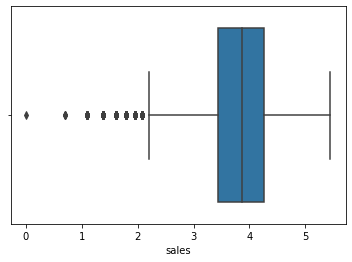

In [33]:
sns.boxplot(train['sales'])

In [34]:
IQR=train.sales.quantile(0.75)-train.sales.quantile(0.25)
lower_bridge=train['sales'].quantile(0.25)-(IQR*1.5)
upper_bridge=train['sales'].quantile(0.75)+(IQR*1.5)
print(lower_bridge), print(upper_bridge)

2.1909481956508925
5.505718885875569


(None, None)

In [35]:
lower_bridge=train['sales'].quantile(0.25)-(IQR*3)
upper_bridge=train['sales'].quantile(0.75)+(IQR*3)
print(lower_bridge), print(upper_bridge)

0.9479091868166387
6.748757894709823


(None, None)

In [37]:
train.loc[train['sales']>=6.748757894709823,'sales']=6.748757894709823
train.loc[train['sales']<=2.1909481956508925,'sales']=2.1909481956508925


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


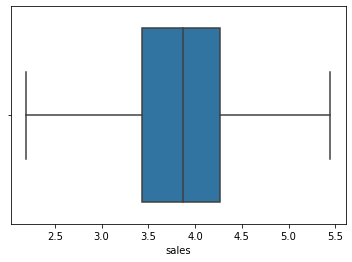

In [38]:
sns.boxplot(train['sales'])

In [39]:
train.to_csv('/content/drive/MyDrive/dataset/demand-forecasting-kernels-only/final_train.csv',index=False)